<a href="https://colab.research.google.com/github/leifolson/tf-cert-practice/blob/main/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Check GPU since we plan to used mixed precision.  Need a Tesla T4 or better.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fbdf4546-2d5b-17ba-1c07-253b8218b1df)


In [3]:
# grab a few helper functions
!wget "https://raw.githubusercontent.com/leifolson/tf-cert-practice/main/helper_functions.py"

--2024-01-31 23:52:01--  https://raw.githubusercontent.com/leifolson/tf-cert-practice/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-31 23:52:02 (93.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Using Food-101 from TF Datasets

In [5]:
import tensorflow_datasets as tfds

In [6]:
[d for d in tfds.list_builders() if 'food' in d]

['food101', 'huggingface:food101', 'robotics:cmu_playing_with_food']

In [7]:
(train_data, test_data), ds_info = tfds.load('food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteEXU61E/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteEXU61E/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [8]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpq_y_5rfjtfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [9]:
example = list(train_data.take(1))[0]

In [10]:
image, label = example

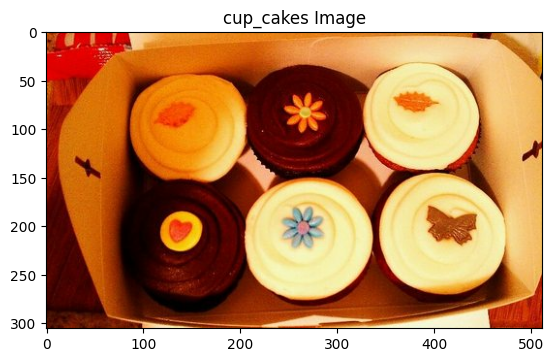

In [11]:
plt.imshow(image)
plt.title('{} Image'.format(ds_info.features['label'].names[label]));

## Preprocessing

In [12]:
def preprocess(image, label, img_shape=(224, 224)):
  """
  Reshape and change datatype to float32
  """
  image = tf.image.resize(image, img_shape)
  image = tf.cast(image, tf.float32)
  return image, label

In [13]:
image.dtype, image.shape

(tf.uint8, TensorShape([306, 512, 3]))

In [14]:
image2, label2 = preprocess(image, label)

In [15]:
image2.dtype, image2.shape, label2

(tf.float32,
 TensorShape([224, 224, 3]),
 <tf.Tensor: shape=(), dtype=int64, numpy=29>)

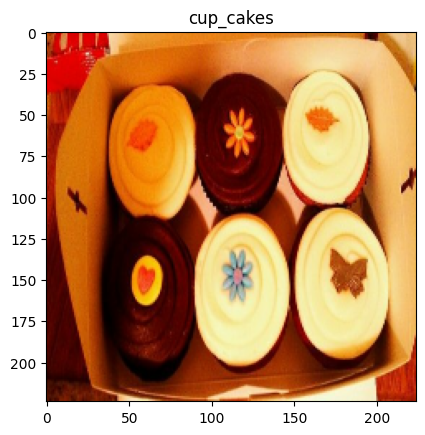

In [16]:
plt.imshow(image2.numpy() / 255.)
plt.title(ds_info.features['label'].names[label2]);

In [17]:
# prepare train and test data
train_data = train_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10_000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Setting up checkpoints


In [19]:
ckpt_path = 'model_checkpoints/cp.ckpt'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

## Set up mixed precision training

In [21]:
from tensorflow.keras import mixed_precision

In [22]:
mixed_precision.set_global_policy('mixed_float16')

## Create Model

In [23]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=(224, 224, 3))

16705208/16705208 [==============================] - 2s 0us/step


In [27]:
from tensorflow.keras import layers
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
hist_feature_extract = model.fit(train_data, epochs=3,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=int(0.15 * len(test_data)),
                                 callbacks=[create_tensorboard_callback("training_logs",
                                                                        "efficientnetb0_101_classes_all_data_feature_extract"),
                                            model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240201-001048
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7166 - accuracy: 0.5821

2368/2368 [==============================] - 113s 42ms/step - loss: 1.7166 - accuracy: 0.5821 - val_loss: 1.1320 - val_accuracy: 0.6999
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.6889

2368/2368 [==============================] - 103s 42ms/step - loss: 1.1989 - accuracy: 0.6889 - val_loss: 1.0349 - val_accuracy: 0.7206
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0544 - accuracy: 0.7236

2368/2368 [==============================] - 104s 42ms/step - loss: 1.0544 - accuracy: 0.7236 - val_loss: 1.0020 - val_accuracy: 0.7262


In [31]:
model.evaluate(test_data)

790/790 [==============================] - 28s 36ms/step - loss: 1.0052 - accuracy: 0.7277


[1.0052074193954468, 0.7276831865310669]